In [1]:
# comet-ml must be imported before torch and sklearn
import comet_ml
import scanpy as sc
import pandas as pd

import mvtcr.utils_training as utils
utils.fix_seeds(42) #This sets torch.manual_seed, np.random.seed, random.seed for reproducibility; optuna sampler seed can be set later

In [2]:
path_data = '../datasets/02_dex_annotated_cd8_new.h5ad'
adata = sc.read(path_data)
adata.obs['set'].value_counts()
adata

AnnData object with n_obs × n_vars = 44310 × 5000
    obs: '%_max_dextramer', 'ATDSLNNEY', 'C0251_A02', 'C0251_A08', 'C0252_A03', 'C0252_A04', 'C0253_A04', 'C0253_A05', 'C0254_A05', 'C0254_A11', 'C0255_A06', 'C0255_A15', 'C0256_A11', 'C0256_A29', 'C0257_A15', 'C0257_A19', 'C0258_A25', 'C0258_A29', 'CCR7', 'CD4 NV/CM_score', 'CD4/CD8_score', 'CD45RA', 'CD62L', 'CD8 Cytokine_score', 'CD8 Cytotoxic_score', 'CTELKLSDY', 'CXCR3', 'FLRGRAYGL', 'FPQSAPHGV', 'GTHWFVTQR', 'HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6', 'HA7', 'HA8', 'Hu.CD101', 'Hu.CD103', 'Hu.CD105_43A3', 'Hu.CD107a', 'Hu.CD112', 'Hu.CD119', 'Hu.CD11a', 'Hu.CD11b', 'Hu.CD11c', 'Hu.CD122', 'Hu.CD123', 'Hu.CD124', 'Hu.CD127', 'Hu.CD13', 'Hu.CD134', 'Hu.CD137', 'Hu.CD141', 'Hu.CD146', 'Hu.CD14_M5E2', 'Hu.CD152', 'Hu.CD154', 'Hu.CD155', 'Hu.CD158', 'Hu.CD158b', 'Hu.CD158e1', 'Hu.CD16', 'Hu.CD161', 'Hu.CD163', 'Hu.CD169', 'Hu.CD18', 'Hu.CD183', 'Hu.CD185', 'Hu.CD19', 'Hu.CD194', 'Hu.CD195', 'Hu.CD196', 'Hu.CD1c', 'Hu.CD1d', 'Hu.CD2', 'Hu

In [3]:
adata

AnnData object with n_obs × n_vars = 44310 × 5000
    obs: '%_max_dextramer', 'ATDSLNNEY', 'C0251_A02', 'C0251_A08', 'C0252_A03', 'C0252_A04', 'C0253_A04', 'C0253_A05', 'C0254_A05', 'C0254_A11', 'C0255_A06', 'C0255_A15', 'C0256_A11', 'C0256_A29', 'C0257_A15', 'C0257_A19', 'C0258_A25', 'C0258_A29', 'CCR7', 'CD4 NV/CM_score', 'CD4/CD8_score', 'CD45RA', 'CD62L', 'CD8 Cytokine_score', 'CD8 Cytotoxic_score', 'CTELKLSDY', 'CXCR3', 'FLRGRAYGL', 'FPQSAPHGV', 'GTHWFVTQR', 'HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6', 'HA7', 'HA8', 'Hu.CD101', 'Hu.CD103', 'Hu.CD105_43A3', 'Hu.CD107a', 'Hu.CD112', 'Hu.CD119', 'Hu.CD11a', 'Hu.CD11b', 'Hu.CD11c', 'Hu.CD122', 'Hu.CD123', 'Hu.CD124', 'Hu.CD127', 'Hu.CD13', 'Hu.CD134', 'Hu.CD137', 'Hu.CD141', 'Hu.CD146', 'Hu.CD14_M5E2', 'Hu.CD152', 'Hu.CD154', 'Hu.CD155', 'Hu.CD158', 'Hu.CD158b', 'Hu.CD158e1', 'Hu.CD16', 'Hu.CD161', 'Hu.CD163', 'Hu.CD169', 'Hu.CD18', 'Hu.CD183', 'Hu.CD185', 'Hu.CD19', 'Hu.CD194', 'Hu.CD195', 'Hu.CD196', 'Hu.CD1c', 'Hu.CD1d', 'Hu.CD2', 'Hu

In [4]:
adata.obs['IFN_Response_score_bin'] = pd.qcut(
    adata.obs['IFN Response_score'], 
    q=4,  # Divide into quartiles; adjust q for finer bins
    labels=['low', 'medium-low', 'medium-high', 'high']
)

In [5]:
adata.obs['IFN_Response_score_bin'].value_counts()

IFN_Response_score_bin
low            11078
high           11078
medium-low     11077
medium-high    11077
Name: count, dtype: int64

In [6]:
params_experiment = {
    'study_name': 'vaccine Simulator',
    'comet_workspace': None, 
    'model_name': 'moe',
    'balanced_sampling': 'clonotype',
    'metadata': [],
    'save_path': '../saved_models/vaccine_Simulator_IFN_bins',
    'conditional': 'donor_ohe',
    'n_epochs': 10,
}

In [7]:
params_optimization = {
    'name': 'pseudo_metric',
    'prediction_labels':
        {'IFN_Response_score_bin': 1}
}

In [ ]:
from mvtcr.models.model_selection import run_model_selection

timeout = (20*60)
n_samples = 3
n_gpus = 1
seed = 42
run_model_selection(adata, params_experiment, params_optimization, n_samples, timeout, n_gpus, sampler_seed=seed)


In [8]:
path_model = '/Users/tristanaretz/Desktop/Master_Bioinformatik/WiSe_24_25/singlecell/project/saved_models/concat/saved_models/vaccine_Simulator/trial_2/best_model_by_metric.pt'
model = utils.load_model(adata, path_model)

In [9]:
print(model)

In [30]:
latent_moe = model.get_latent(adata, metadata=[], return_mean=True, copy_adata_obs=True)


In [31]:
latent_moe

AnnData object with n_obs × n_vars = 44310 × 10
    obs: '%_max_dextramer', 'ATDSLNNEY', 'C0251_A02', 'C0251_A08', 'C0252_A03', 'C0252_A04', 'C0253_A04', 'C0253_A05', 'C0254_A05', 'C0254_A11', 'C0255_A06', 'C0255_A15', 'C0256_A11', 'C0256_A29', 'C0257_A15', 'C0257_A19', 'C0258_A25', 'C0258_A29', 'CCR7', 'CD4 NV/CM_score', 'CD4/CD8_score', 'CD45RA', 'CD62L', 'CD8 Cytokine_score', 'CD8 Cytotoxic_score', 'CTELKLSDY', 'CXCR3', 'FLRGRAYGL', 'FPQSAPHGV', 'GTHWFVTQR', 'HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6', 'HA7', 'HA8', 'Hu.CD101', 'Hu.CD103', 'Hu.CD105_43A3', 'Hu.CD107a', 'Hu.CD112', 'Hu.CD119', 'Hu.CD11a', 'Hu.CD11b', 'Hu.CD11c', 'Hu.CD122', 'Hu.CD123', 'Hu.CD124', 'Hu.CD127', 'Hu.CD13', 'Hu.CD134', 'Hu.CD137', 'Hu.CD141', 'Hu.CD146', 'Hu.CD14_M5E2', 'Hu.CD152', 'Hu.CD154', 'Hu.CD155', 'Hu.CD158', 'Hu.CD158b', 'Hu.CD158e1', 'Hu.CD16', 'Hu.CD161', 'Hu.CD163', 'Hu.CD169', 'Hu.CD18', 'Hu.CD183', 'Hu.CD185', 'Hu.CD19', 'Hu.CD194', 'Hu.CD195', 'Hu.CD196', 'Hu.CD1c', 'Hu.CD1d', 'Hu.CD2', 'Hu.C

In [12]:
sc.pp.neighbors(latent_moe, use_rep='X')
sc.tl.umap(latent_moe)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [13]:
# sc.pl.umap(latent_moe, color=['clonotype', 'donor'])

In [14]:
latent_moe

AnnData object with n_obs × n_vars = 44310 × 10
    obs: '%_max_dextramer', 'ATDSLNNEY', 'C0251_A02', 'C0251_A08', 'C0252_A03', 'C0252_A04', 'C0253_A04', 'C0253_A05', 'C0254_A05', 'C0254_A11', 'C0255_A06', 'C0255_A15', 'C0256_A11', 'C0256_A29', 'C0257_A15', 'C0257_A19', 'C0258_A25', 'C0258_A29', 'CCR7', 'CD4 NV/CM_score', 'CD4/CD8_score', 'CD45RA', 'CD62L', 'CD8 Cytokine_score', 'CD8 Cytotoxic_score', 'CTELKLSDY', 'CXCR3', 'FLRGRAYGL', 'FPQSAPHGV', 'GTHWFVTQR', 'HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6', 'HA7', 'HA8', 'Hu.CD101', 'Hu.CD103', 'Hu.CD105_43A3', 'Hu.CD107a', 'Hu.CD112', 'Hu.CD119', 'Hu.CD11a', 'Hu.CD11b', 'Hu.CD11c', 'Hu.CD122', 'Hu.CD123', 'Hu.CD124', 'Hu.CD127', 'Hu.CD13', 'Hu.CD134', 'Hu.CD137', 'Hu.CD141', 'Hu.CD146', 'Hu.CD14_M5E2', 'Hu.CD152', 'Hu.CD154', 'Hu.CD155', 'Hu.CD158', 'Hu.CD158b', 'Hu.CD158e1', 'Hu.CD16', 'Hu.CD161', 'Hu.CD163', 'Hu.CD169', 'Hu.CD18', 'Hu.CD183', 'Hu.CD185', 'Hu.CD19', 'Hu.CD194', 'Hu.CD195', 'Hu.CD196', 'Hu.CD1c', 'Hu.CD1d', 'Hu.CD2', 'Hu.C

In [15]:
latent_moe.obs['donor']

cell_id
AAACCTGAGTGTTGAA-1-initial-0-0    A15
AAACCTGCACCAGGCT-1-initial-0-0    A29
AAACCTGCATACGCTA-1-initial-0-0    A15
AAACGGGGTACGAAAT-1-initial-0-0    A29
AAACGGGGTATTAGCC-1-initial-0-0    A06
                                 ... 
TTTGCGCTCTCTGAGA-1-2-1            A05
TTTGGTTGTTCGGGCT-1-2-1            A05
TTTGGTTTCCACGACG-1-2-1            A08
TTTGTCACAGCTGCAC-1-2-1            A08
TTTGTCATCCTATGTT-1-2-1            A08
Name: donor, Length: 44310, dtype: category
Categories (14, object): ['A02', 'A03', 'A04', 'A05', ..., 'A19', 'A25', 'A29', 'HIM']

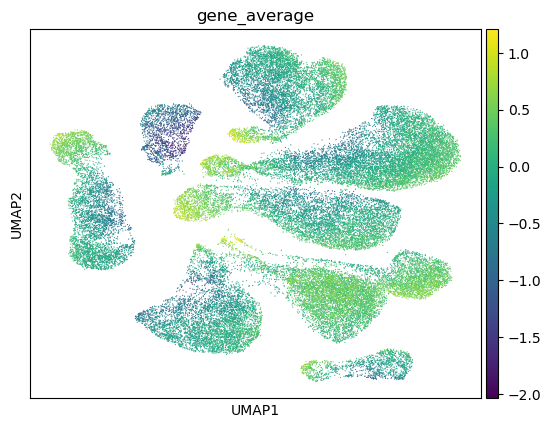

In [16]:
cell_averages = latent_moe.X.mean(axis=1) 
latent_moe.obs['gene_average'] = cell_averages

sc.pl.umap(latent_moe, color=['gene_average'])

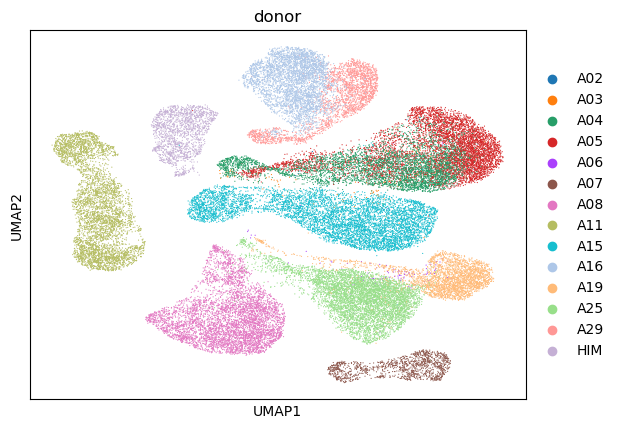

In [17]:
sc.pl.umap(latent_moe, color=['donor'])

In [18]:
latent_moe[latent_moe.obs['donor'] == 'A04']

View of AnnData object with n_obs × n_vars = 4458 × 10
    obs: '%_max_dextramer', 'ATDSLNNEY', 'C0251_A02', 'C0251_A08', 'C0252_A03', 'C0252_A04', 'C0253_A04', 'C0253_A05', 'C0254_A05', 'C0254_A11', 'C0255_A06', 'C0255_A15', 'C0256_A11', 'C0256_A29', 'C0257_A15', 'C0257_A19', 'C0258_A25', 'C0258_A29', 'CCR7', 'CD4 NV/CM_score', 'CD4/CD8_score', 'CD45RA', 'CD62L', 'CD8 Cytokine_score', 'CD8 Cytotoxic_score', 'CTELKLSDY', 'CXCR3', 'FLRGRAYGL', 'FPQSAPHGV', 'GTHWFVTQR', 'HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6', 'HA7', 'HA8', 'Hu.CD101', 'Hu.CD103', 'Hu.CD105_43A3', 'Hu.CD107a', 'Hu.CD112', 'Hu.CD119', 'Hu.CD11a', 'Hu.CD11b', 'Hu.CD11c', 'Hu.CD122', 'Hu.CD123', 'Hu.CD124', 'Hu.CD127', 'Hu.CD13', 'Hu.CD134', 'Hu.CD137', 'Hu.CD141', 'Hu.CD146', 'Hu.CD14_M5E2', 'Hu.CD152', 'Hu.CD154', 'Hu.CD155', 'Hu.CD158', 'Hu.CD158b', 'Hu.CD158e1', 'Hu.CD16', 'Hu.CD161', 'Hu.CD163', 'Hu.CD169', 'Hu.CD18', 'Hu.CD183', 'Hu.CD185', 'Hu.CD19', 'Hu.CD194', 'Hu.CD195', 'Hu.CD196', 'Hu.CD1c', 'Hu.CD1d', 'Hu.CD2'

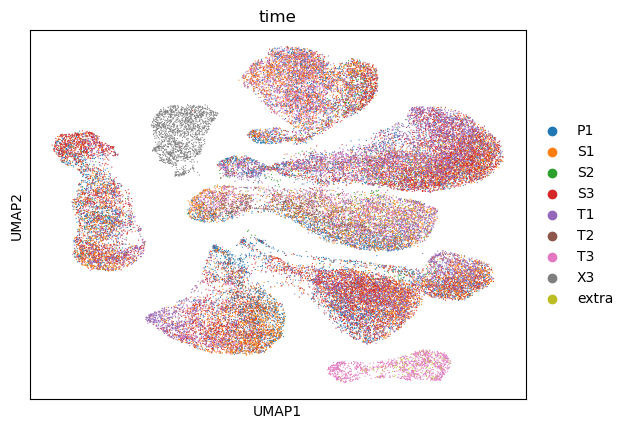

In [19]:
sc.pl.umap(latent_moe, color=['time'])

In [20]:
latent_moe.obs_names

Index(['AAACCTGAGTGTTGAA-1-initial-0-0', 'AAACCTGCACCAGGCT-1-initial-0-0',
       'AAACCTGCATACGCTA-1-initial-0-0', 'AAACGGGGTACGAAAT-1-initial-0-0',
       'AAACGGGGTATTAGCC-1-initial-0-0', 'AAACGGGTCACAACGT-1-initial-0-0',
       'AAAGATGGTGTGACGA-1-initial-0-0', 'AAAGCAAAGTGTCCAT-1-initial-0-0',
       'AAAGCAATCGTTTAGG-1-initial-0-0', 'AAAGTAGCAAGCTGTT-1-initial-0-0',
       ...
       'TTTCCTCCATCAGTAC-1-2-1', 'TTTGCGCAGTCTCAAC-1-2-1',
       'TTTGCGCGTACATCCA-1-2-1', 'TTTGCGCGTGTGGCTC-1-2-1',
       'TTTGCGCTCCAGGGCT-1-2-1', 'TTTGCGCTCTCTGAGA-1-2-1',
       'TTTGGTTGTTCGGGCT-1-2-1', 'TTTGGTTTCCACGACG-1-2-1',
       'TTTGTCACAGCTGCAC-1-2-1', 'TTTGTCATCCTATGTT-1-2-1'],
      dtype='object', name='cell_id', length=44310)

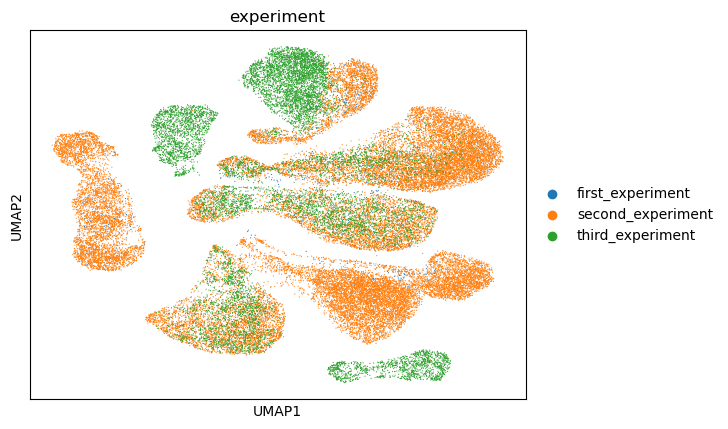

In [21]:
sc.pl.umap(latent_moe, color=['experiment'])

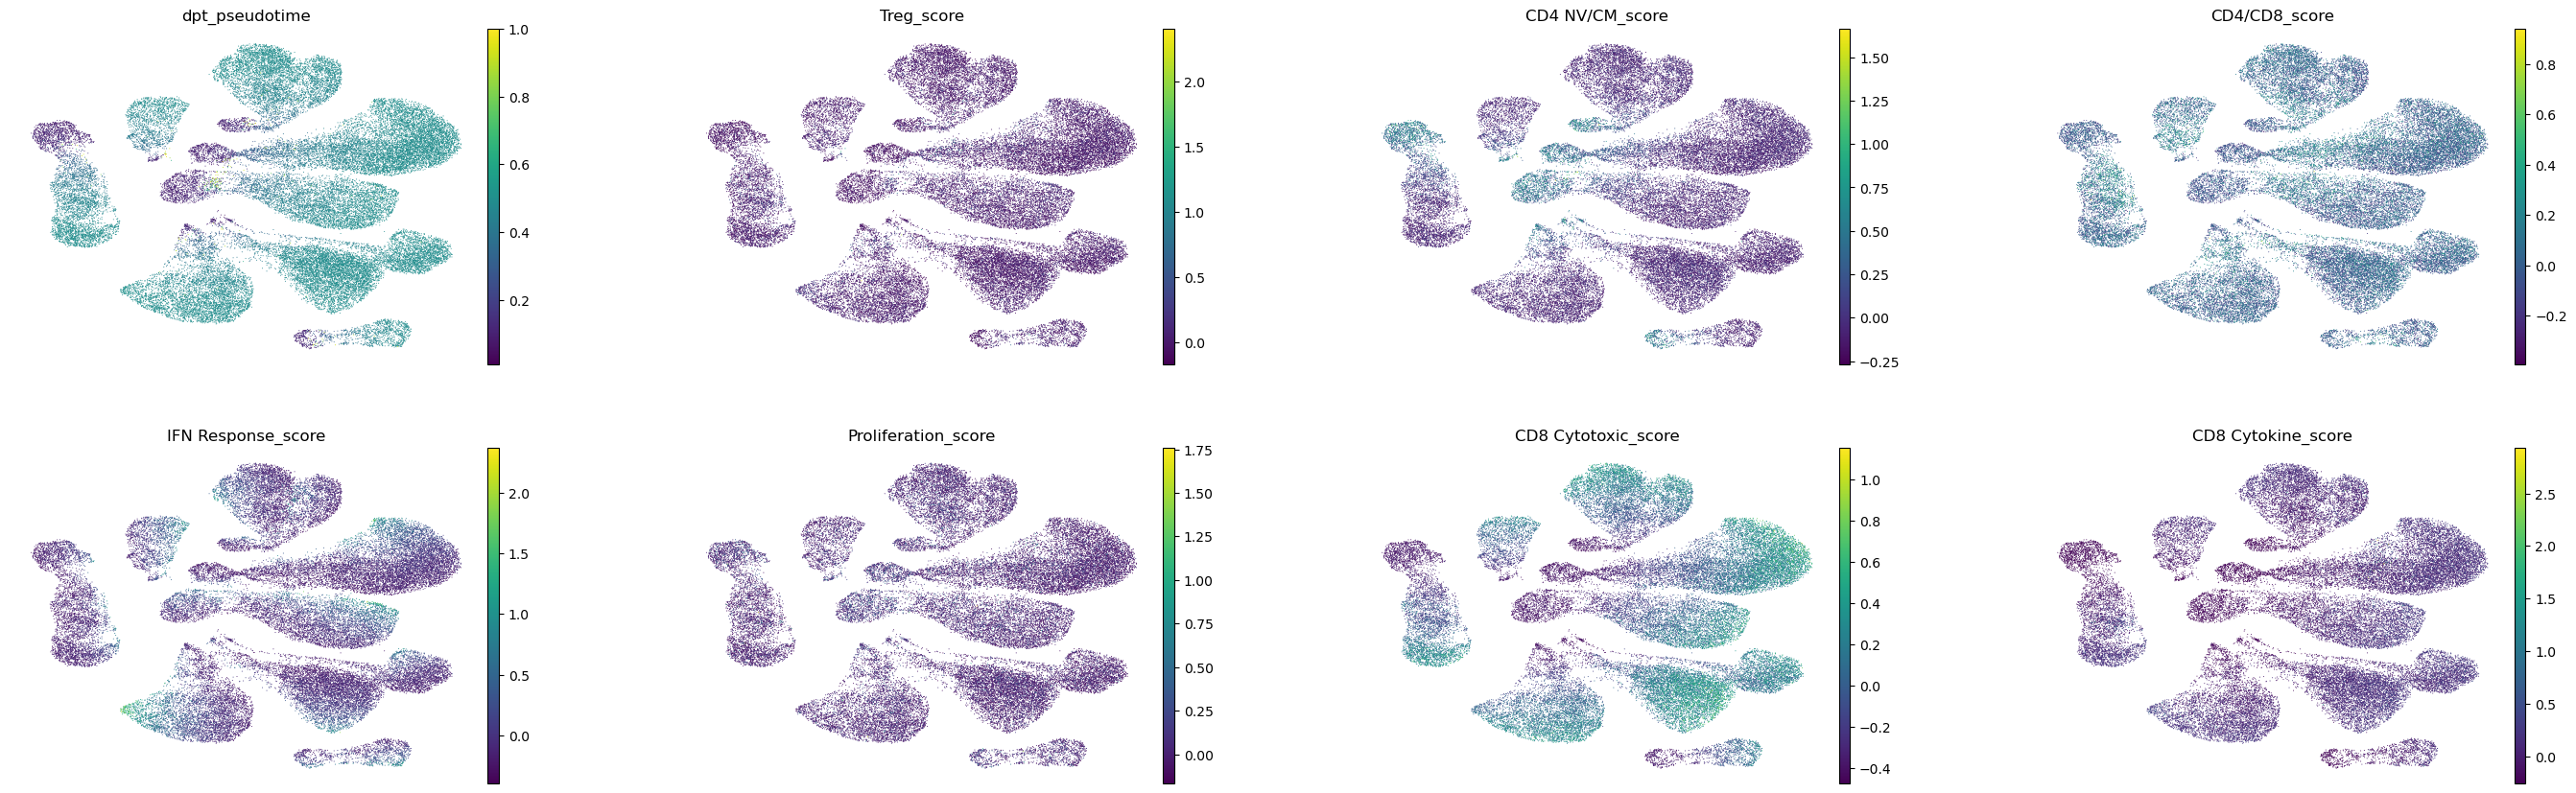

In [22]:
sc.pl.umap(latent_moe, frameon=False, wspace=0.3, size=2, cmap='viridis',
           color=['dpt_pseudotime', 'Treg_score', 'CD4 NV/CM_score', 'CD4/CD8_score', 'IFN Response_score', 'Proliferation_score', 'CD8 Cytotoxic_score', 'CD8 Cytokine_score'], )

In [23]:
# Extract UMAP embeddings
umap_embeddings = latent_moe.obsm['X_umap']

In [24]:
umap_embeddings.shape

(44310, 2)

In [25]:
path_out = '../datasets/02_dex_annotated_cd8_mvTCR_concat.h5ad'
latent_moe.write_h5ad(path_out, compression='gzip')

In [26]:
latent_moe

AnnData object with n_obs × n_vars = 44310 × 10
    obs: '%_max_dextramer', 'ATDSLNNEY', 'C0251_A02', 'C0251_A08', 'C0252_A03', 'C0252_A04', 'C0253_A04', 'C0253_A05', 'C0254_A05', 'C0254_A11', 'C0255_A06', 'C0255_A15', 'C0256_A11', 'C0256_A29', 'C0257_A15', 'C0257_A19', 'C0258_A25', 'C0258_A29', 'CCR7', 'CD4 NV/CM_score', 'CD4/CD8_score', 'CD45RA', 'CD62L', 'CD8 Cytokine_score', 'CD8 Cytotoxic_score', 'CTELKLSDY', 'CXCR3', 'FLRGRAYGL', 'FPQSAPHGV', 'GTHWFVTQR', 'HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6', 'HA7', 'HA8', 'Hu.CD101', 'Hu.CD103', 'Hu.CD105_43A3', 'Hu.CD107a', 'Hu.CD112', 'Hu.CD119', 'Hu.CD11a', 'Hu.CD11b', 'Hu.CD11c', 'Hu.CD122', 'Hu.CD123', 'Hu.CD124', 'Hu.CD127', 'Hu.CD13', 'Hu.CD134', 'Hu.CD137', 'Hu.CD141', 'Hu.CD146', 'Hu.CD14_M5E2', 'Hu.CD152', 'Hu.CD154', 'Hu.CD155', 'Hu.CD158', 'Hu.CD158b', 'Hu.CD158e1', 'Hu.CD16', 'Hu.CD161', 'Hu.CD163', 'Hu.CD169', 'Hu.CD18', 'Hu.CD183', 'Hu.CD185', 'Hu.CD19', 'Hu.CD194', 'Hu.CD195', 'Hu.CD196', 'Hu.CD1c', 'Hu.CD1d', 'Hu.CD2', 'Hu.C

In [27]:
latent_moe.obsp

PairwiseArrays with keys: distances, connectivities

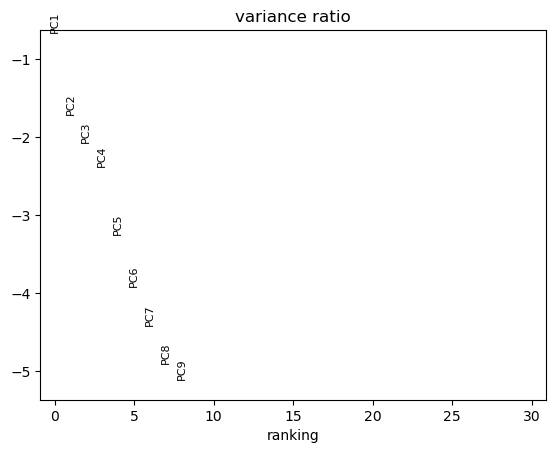

In [28]:
sc.pp.pca(latent_moe)
sc.pl.pca_variance_ratio(latent_moe, log=True)

# Compute variance explained by donor
sc.tl.pca(latent_moe)
sc.pp.regress_out(latent_moe, ['donor'])